#### Model

Architecture incorporates three convolutional and maxpooling layers,  followed by two fully connected (dense) layers, a dropout layer (to assist with potential overfitting), and finally a non-linear layer. As this model is a binary classification, in that the intent of this model is to determine whether or not smoke is present within an image, the sigmoid activation function is used. Each activation function is ReLu (aside from the aforementioned sigmoid), the loss function is binary crossentropy, and the optimizer is Adam.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import datetime, os
import tensorflow as tf

from imutils import paths
import os
import shutil
import random
import filecmp

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array

import itertools    

from sklearn.metrics import confusion_matrix

In [2]:
# Installs (if needed)
!pip install imutils
!pip install opencv-python

#### Extract data from the following source and save to `grid_version.tar`

In [3]:
!wget "https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar"

--2022-04-16 15:18:50--  https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rl0qbub4clah2w9/grid_version.tar [following]
--2022-04-16 15:18:51--  https://www.dropbox.com/s/raw/rl0qbub4clah2w9/grid_version.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc912a0e1130711ac5211528aaef.dl.dropboxusercontent.com/cd/0/inline/BjggjOdsWlyv8pt1pt4hBXl71KoTWJedy4gihww4g3eTlVcee5ctC2Z0ASmvGUJMgyXc__GCBx3HV5su3k2YNA4myYaDXwi_0R5Z87lpbuouFh6Bj4V_fifBCUlr7ad0IfS_eBxtyxECF4bNPAScjTfWpezMnpCDc0_i6yaGTXlFwg/file# [following]
--2022-04-16 15:18:51--  https://uc912a0e1130711ac5211528aaef.dl.dropboxusercontent.com/cd/0/inline/BjggjOdsWlyv8pt1pt4hBXl71KoTWJedy4gihww4g3eTlVcee5ctC2Z0

#### Unzip data to `grid_version` directory

In [4]:
!tar -xvf 'grid_version.tar'

grid_version/
grid_version/validate/
grid_version/.DS_Store
grid_version/train/
grid_version/train/grid_no_smoke/
grid_version/train/.DS_Store
grid_version/train/grid_smoke/
grid_version/train/grid_smoke/1529002100_+01140_05_03.png
grid_version/train/grid_smoke/1529003240_+02280_05_03.png
grid_version/train/grid_smoke/1499547403_+01140_03_06.png
grid_version/train/grid_smoke/1499547763_+01500_05_07.png
grid_version/train/grid_smoke/1529002880_+01920_05_03.png
grid_version/train/grid_smoke/1528759446_+02040_06_08.png
grid_version/train/grid_smoke/1528759506_+02100_06_04.png
grid_version/train/grid_smoke/1498418253_+01860_05_08.png
grid_version/train/grid_smoke/1498418493_+02100_04_09.png
grid_version/train/grid_smoke/1529001560_+00600_06_04.png
grid_version/train/grid_smoke/1499547283_+01020_04_06.png
grid_version/train/grid_smoke/1528759686_+02280_05_06.png
grid_version/train/grid_smoke/1529022805_+02100_05_05.png
grid_version/train/grid_smoke/1530740065_+01020_04_07.png
grid_version/t

#### Split the data randomly into `sampled_train`, `sampled_validate`, and `testing` directories

In [5]:
# Source: https://github.com/tsofoon/wildfire/blob/master/WildfireSmokeImageClassifier_MT_best_model.ipynb 
# Although, was modified quite a bit from the original source

def split_data(directory, validate_directory='validation', split_train=0.85, split_validate=0.1): 
    directories = [os.path.join(directory, o) for o in os.listdir(directory) 
                    if os.path.isdir(os.path.join(directory,o))]
    print(directories)
    
    # create file path variables
    new_train_dir = './sampled_train'
    new_val_dir = './sampled_validate'
    testing_dir = './testing'
    
    # remove existing directories
    if os.path.isdir(new_train_dir) is True:
        shutil.rmtree(new_train_dir)
        shutil.rmtree(new_val_dir)
        shutil.rmtree(testing_dir)
    
    # create empty directories
    os.makedirs(new_train_dir)
    os.makedirs(new_val_dir)
    os.makedirs(testing_dir)
    
    for directory in directories:
        image_paths = list(paths.list_images(directory))
    
        random.seed(32)
        random.shuffle(image_paths)
        image_paths

        # compute the train, validate, and testing split
        i = int(len(image_paths) * split_train)
        j = int(len(image_paths) * split_validate)
        
        train_paths = image_paths[:i]
        selected_for_validation_paths = image_paths[i:i+j]
        test_paths = image_paths[i+j:]

        for path in selected_for_validation_paths:
            category = os.path.basename(os.path.normpath(directory))
            dest_path = os.path.join(new_val_dir, category)
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)
            shutil.move(path, dest_path)

        for path in train_paths:
            category = os.path.basename(os.path.normpath(directory))
            dest_path = os.path.join(new_train_dir, category)
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)
            shutil.move(path, dest_path)  
            
        for path in test_paths:
            category = os.path.basename(os.path.normpath(directory))
            dest_path = os.path.join(testing_dir, category)
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)
            shutil.move(path, dest_path)  

In [6]:
split_data(directory='grid_version/train/', validate_directory='grid_version/validation')  

['grid_version/train/grid_no_smoke', 'grid_version/train/grid_smoke']


#### Evaluating `like` images by directory
I believe that the images are named with an epoch unix timestamp; the next few cells parse the 
filename to then generate a list of the unique filenames, using the partial filename. 
This is merely for curiosity in analyzing `like` images amongst directories.

In [7]:
sample_train_smoke = os.listdir('./sampled_train/grid_smoke/')

image_list = []
sampled_train_unique_list = []   
for image in sample_train_smoke:
    if image.endswith('.png'):
        image_list.append(image.split("_")[0])

    for parsed_img in image_list:
        if parsed_img not in sampled_train_unique_list:
            sampled_train_unique_list.append(parsed_img)
        else:
            continue        
                
len(sampled_train_unique_list), sorted(sampled_train_unique_list[:5])

(237, ['1499548063', '1499548123', '1512674344', '1512676144', '1528759806'])

In [8]:
sample_validate_smoke = os.listdir('./sampled_validate/grid_smoke/')

image_list = []
sampled_validate_unique_list = []   
for image in sample_validate_smoke:
    if image.endswith('.png'):
        image_list.append(image.split("_")[0])

    for parsed_img in image_list:
        if parsed_img not in sampled_validate_unique_list:
            sampled_validate_unique_list.append(parsed_img)
        else:
            continue        
                
len(sampled_validate_unique_list), sorted(sampled_validate_unique_list[:5])

(75, ['1499548003', '1499548363', '1529001740', '1529003300', '1529021905'])

In [9]:
testing_list_smoke = os.listdir('./testing/grid_smoke/')

image_list = []
testing_unique_list = []   
for image in testing_list_smoke:
    if image.endswith('.png'):
        image_list.append(image.split("_")[0])

    for parsed_img in image_list:
        if parsed_img not in testing_unique_list:
            testing_unique_list.append(parsed_img)
        else:
            continue        
                
len(sorted(testing_unique_list)), sorted(testing_unique_list[:5])

(45, ['1528758666', '1528759386', '1529001680', '1529002280', '1529002940'])

In [10]:
# Compare lists for overlap -- in this case, using the function on the previous cells

def intersection(lst1, lst2):
    intersect = [value for value in lst1 if value in lst2]
    return len(intersect)

In [11]:
intersection(sampled_train_unique_list, sampled_validate_unique_list), intersection(sampled_train_unique_list, testing_unique_list)

(69, 43)

In [12]:
# Save newly generate file paths as variables

train_path = 'sampled_train'
validate_path = 'sampled_validate'
testing_path = 'testing'

#### Image Augmentation

Image augmentation is used to enhance the size and quality of training datasets for the purpose of creating more accurate Deep Learning models. Image augmentation algorithms vary in how the types of augmentation or transformations take place. Some of the methods include geometric transformations, color space augmentations, kernel filters, feature space augmentation, and so on. 

Many of the approaches used in this model were derived from the following source: (https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844) 

---

**Definitions of Methods Applied**

**preprocessing_function:** The **vgg16.preprocess_input** distorts the color of an image. It does so by subtracting the mean RGB value from each pixel in the image. For example, it will calculate the mean value for all red pixels within an image, then subtract that mean value from each red pixel in the image. This will also be done for green and blue.

**rescale:** Scales image to defined scale

**shear_range:** This method slants the shape of the image. This is different from rotation in the sense that in **shear_range**, we fix one axis and stretch the image at a certain angle known as the shear angle. This creates a sort of ‘stretch’ in the image, which is not seen in rotation. The angle of the slant is represented in degrees.

**zoom_range:** A random zoom is obtained by the **zoom_range** argument. A zoom less than 1.0 magnifies the image, while a zoom greater than 1.0 zooms out of the image.

**horizontal_flip:** The generator will generate images, which on a random basis, will be horizontally flipped.


In [13]:
# Apply image augmentation
train_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
    
validate_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1. /255
)

testing_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1. /255
)

In [14]:
# Variables for model
batch_size = 64
image_width = 256 
image_height = 256 
input_shape = (image_width, image_height, 3)
classes = ['grid_no_smoke','grid_smoke']
color_mode="rgb"
IMAGE_WIDTH_HEIGHT = (image_width, image_height)

class_mode = 'binary'

# Create 'train_generator' flowing from `sampled_train` directory
train_generator = train_image_generator.flow_from_directory(
            train_path,
            target_size=IMAGE_WIDTH_HEIGHT,
            batch_size=batch_size,
            classes=classes,
            color_mode=color_mode,
            class_mode=class_mode)
            
# Create 'validate_generator' flowing from `sampled_validate` directory
validate_generator = validate_image_generator.flow_from_directory(
        validate_path,
        target_size=IMAGE_WIDTH_HEIGHT,
        batch_size=batch_size,
        classes=classes,
        color_mode=color_mode,
        class_mode=class_mode)

# Create 'testing_generator' flowing from `testing` directory
# Shuffle = False, to ensure we know the labels for predictions
testing_generator = testing_image_generator.flow_from_directory(
        testing_path,
        target_size=IMAGE_WIDTH_HEIGHT,
        batch_size=batch_size,
        classes=classes,
        color_mode=color_mode,
        class_mode=class_mode,
        shuffle=False)

Found 3077 images belonging to 2 classes.
Found 361 images belonging to 2 classes.
Found 183 images belonging to 2 classes.


#### Remove unwanted .ipynb files in `testing` directory
This is merely used to ensure that no hidden or unwanted files are passed to the model.

In [15]:
def remove_files(directory, file_type):
    list_dir = os.listdir(directory)
    
    for item in list_dir:
        if item.endswith(file_type):
            os.remove(os.path.join(directory, item))
        return f"File with extension '{file_type}' not found in {directory}"

In [16]:
remove_files('testing/grid_smoke/', '.ipynb_checkpoints'), remove_files('testing/grid_no_smoke/', '.ipynb_checkpoints')

("File with extension '.ipynb_checkpoints' not found in testing/grid_smoke/",
 "File with extension '.ipynb_checkpoints' not found in testing/grid_no_smoke/")

#### Evaluate if data leakage is present
Check if there are any identical images between the `sampled_train` and `sampled_validate` directories

In [17]:
# grid_smoke directories
val_smoke = 'sampled_validate/grid_smoke/'
train_smoke = 'sampled_train/grid_smoke/'

# grid_no_smoke directories
val_no_smoke = 'sampled_validate/grid_no_smoke/'
train_no_smoke = 'sampled_train/grid_no_smoke/'

In [18]:
def compare_directories(dir1, dir2):
    directory_cmp = filecmp.dircmp(a=dir1, b=dir2)
    print(f"Comparing {dir1.upper()} to {dir2.upper()}")
    print()
    print("Identical Files: {}".format(directory_cmp.same_files))
    print("===" * 25)
    
compare_directories(val_smoke, train_smoke), compare_directories(val_no_smoke, train_no_smoke)

Comparing SAMPLED_VALIDATE/GRID_SMOKE/ to SAMPLED_TRAIN/GRID_SMOKE/

Identical Files: []
Comparing SAMPLED_VALIDATE/GRID_NO_SMOKE/ to SAMPLED_TRAIN/GRID_NO_SMOKE/

Identical Files: []


(None, None)

#### Plot out a sample of images

In [19]:
# Source: https://deeplizard.com/learn/video/LhEMXbjGV_4

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow((img * 255).astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('./Images/image_augmentation.jpg', dpi=100); # save as jpg
    plt.show()

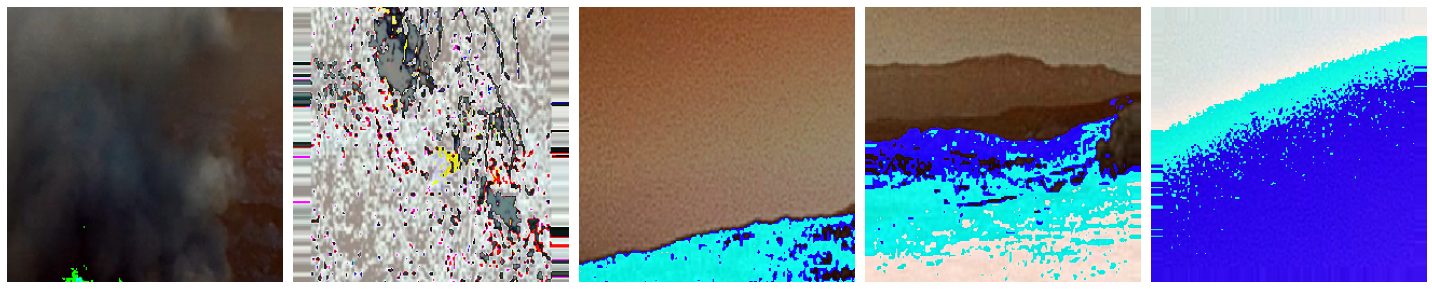

In [20]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:100])

### Neural Network

In [21]:
model = Sequential()
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# output layer - binary // sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

epochs = 10
steps_per_epoch = train_generator.n // train_generator.batch_size
validate_steps = validate_generator.n // validate_generator.batch_size

history = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validate_generator,
      validation_steps=validate_steps,
      epochs=epochs,
)

2022-04-16 15:19:03.916355: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/10
48/48 [==============================] - 122s 3s/step - loss: 0.3943 - accuracy: 0.8075 - val_loss: 0.2361 - val_accuracy: 0.8531
Epoch 2/10
48/48 [==============================] - 121s 3s/step - loss: 0.2031 - accuracy: 0.9031 - val_loss: 0.1397 - val_accuracy: 0.9531
Epoch 3/10
48/48 [==============================] - 120s 2s/step - loss: 0.1335 - accuracy: 0.9273 - val_loss: 0.0957 - val_accuracy: 0.9719
Epoch 4/10
48/48 [==============================] - 120s 2s/step - loss: 0.1112 - accuracy: 0.9612 - val_loss: 0.1475 - val_accuracy: 0.9156
Epoch 5/10
48/48 [==============================] - 123s 3s/step - loss: 0.1152 - accuracy: 0.9598 - val_loss: 0.0601 - val_accuracy: 0.9719
Epoch 6/10
48/48 [==============================] - 120s 3s/step - loss: 0.0880 - accuracy: 0.9695 - val_loss: 0.0464 - val_accuracy: 0.9844
Epoch 7/10
48/48 [==============================] - 120s 2s/step - loss: 0.0544 - accuracy: 0.9804 - val_loss: 0.0367 - val_accuracy: 0.9875
Epoch 8/10
48

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

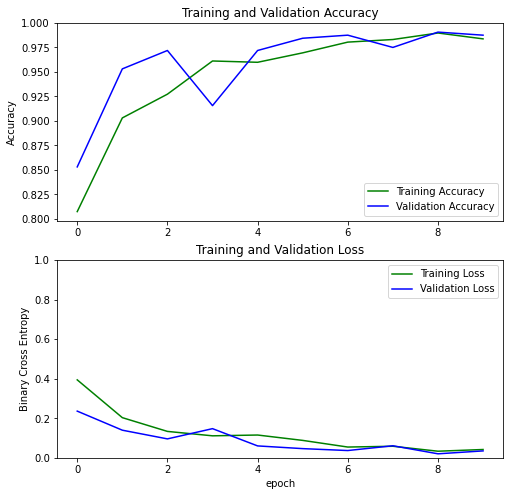

In [23]:
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='green')
plt.plot(val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')
plt.savefig('./Images/accuracy.jpg', dpi=100); # save as jpg

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='green')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('./Images/binary_crossentropy.jpg', dpi=100); # save as jpg;

#### Predictions

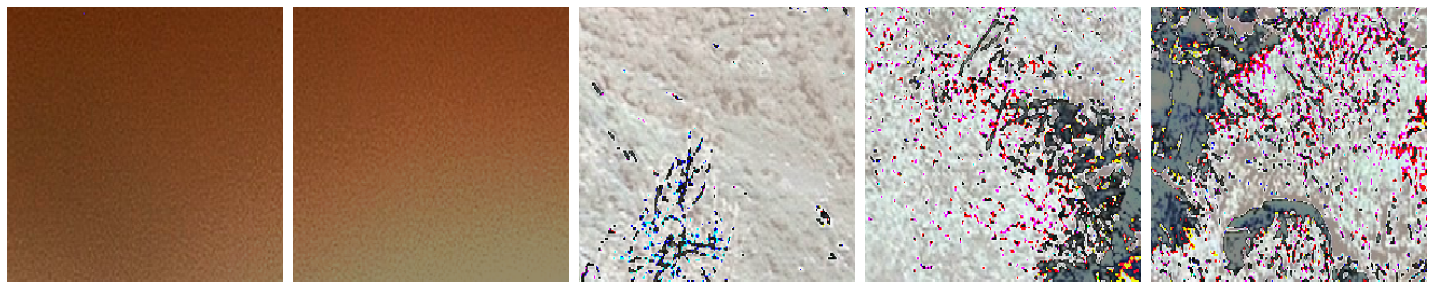

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [24]:
test_imags, test_labels = next(testing_generator)
plotImages(test_imags)
print(test_labels)

In [25]:
predictions = model.predict(x=testing_generator, verbose=0)

In [26]:
np.round(predictions)[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

#### Model Evaluation

In [27]:
cm = confusion_matrix(y_true=testing_generator.classes, y_pred=np.round(predictions))

In [28]:
# Source: https://deeplizard.com/learn/video/bfQBPNDy5EM

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu,
                          ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.savefig('./Images/confusion_matrix.jpg', bbox_inches='tight', dpi=100); # save as jpg

In [29]:
testing_generator.class_indices

{'grid_no_smoke': 0, 'grid_smoke': 1}

Confusion matrix, without normalization


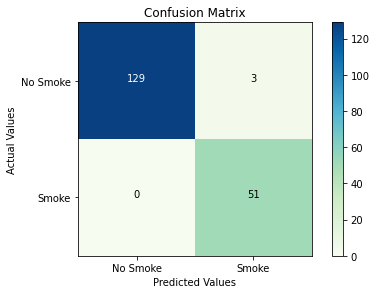

In [30]:
plot_confusion_matrix(cm=cm, classes=['No Smoke', 'Smoke'], normalize=False, title='Confusion Matrix')

In [32]:
print(f'True Positives: {cm[1][1]}')
print(f'True Negatives: {cm[0][0]}')
print(f'False Positives: {cm[0][1]}')
print(f'False Negatives: {cm[1][0]}')

True Positives: 51
True Negatives: 129
False Positives: 3
False Negatives: 0


#### Visualize Filters and Feature Maps in Convolutional Neural Networks

conv2d (3, 3, 3, 32)
32


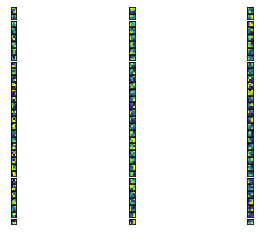

conv2d_1 (3, 3, 32, 32)
32


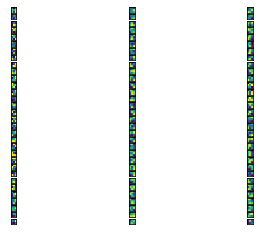

conv2d_2 (3, 3, 32, 64)
64


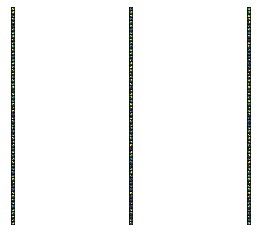

In [33]:
# Source for this cell and the following cell: https://github.com/arshren/Feature-Visualization/blob/master/Feature%20Visualization.ipynb

# Iterate thru all the layers of the model
for layer in model.layers:
    if 'conv' in layer.name:
        # if the layer is a convolutional layer, then extract the weights and bias values
        weights, bias = layer.get_weights()
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(layer.name, filters.shape)
        
        # normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        # 3 because RGB
        print(filters.shape[3])
        filter_cnt=1
        
        # plotting all the filters
        for i in range(filters.shape[3]):
            # get the filters
            filt=filters[:,:,:, i]
            # plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

#### Visualizing feature maps or activation maps generated in a CNN

Feature maps are an intermediate representation for all layers after the first layer.

They are generated by applying Filters or Feature detectors to the input image or the feature map output of the prior layers. Feature map visualization will provide insight into the internal representations (i.e. prominent features) for specific input for each of the Convolutional layers in the model.

(1, 127, 127, 32)
(1, 125, 125, 32)
(1, 62, 62, 32)
(1, 60, 60, 64)
(1, 30, 30, 64)
(1, 57600)
(1, 64)
(1, 64)
(1, 1)
(1, 1)


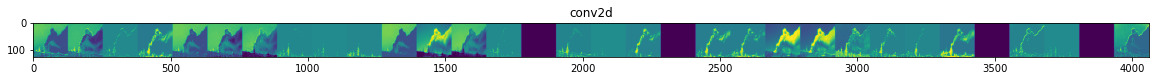

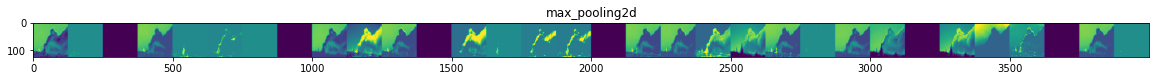

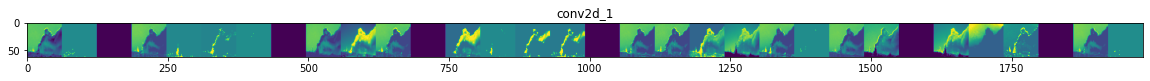

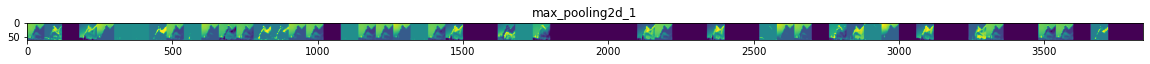

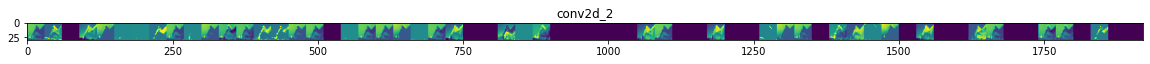

In [34]:
np.seterr(divide='ignore', invalid='ignore')

img_path='./Images/wildfire870.jpeg' #smoke

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
#cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
#dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

#img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(256, 256))  # this is a PIL image

x = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' );

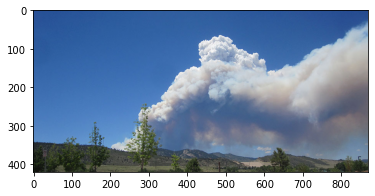

In [35]:
# Actual image evaluated in the feature maps above
img = mpimg.imread('./Images/wildfire870.jpeg')
imgplot = plt.imshow(img)
plt.show()